In [1]:
import pandas as pd
from category_encoders import TargetEncoder

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
# ==========================
# 1. Load Cleaned Data
# ==========================

train_df = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/cleaning_train.csv", index_col=0)
dev_df = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/cleaning_dev.csv", index_col=0)
test_df = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/cleaning_test.csv", index_col=0)

train_df['date'] = pd.to_datetime(train_df['date'])
dev_df['date'] = pd.to_datetime(dev_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

print("Date Range for train data: ", train_df.date.min(), "to ", train_df.date.max())
print("Date Range for dev data: ", dev_df.date.min(), "to ", dev_df.date.max())
print("Date Range for test data: " , test_df.date.min(), "to ", test_df.date.max())

Date Range for train data:  2012-03-31 00:00:00 to  2019-12-31 00:00:00
Date Range for dev data:  2020-01-31 00:00:00 to  2021-12-31 00:00:00
Date Range for test data:  2022-01-31 00:00:00 to  2023-12-31 00:00:00


In [3]:
# ==========================
# 2. Date features
# ==========================
def add_date_features(df):
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month

    # Reorder the dataframe
    df.insert(1, 'year', df.pop("year"))
    df.insert(2, 'quarter', df.pop("quarter"))
    df.insert(3, 'month', df.pop("month"))

    return df
 
train_df = add_date_features(train_df)
dev_df = add_date_features(dev_df)
test_df = add_date_features(test_df)   

In [4]:
train_df.head(2)

,date,year,quarter,month,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,city,zipcode,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full,lat,lng
0,2012-03-31,2012,1,3,46550.0,217450.0,31.813674,110.183666,14.0,23.0,44.0,64.0,59.5,0.943662,0.142857,0.043478,ATL,30002,12.0,2.0,4.0,1.0,60.0,45.0,57.0,4.0,7.0,5811.0,36.3,33052.0,5811.0,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,200773.999557,Atlanta-Sandy Springs-Roswell,33.7338,-84.3922
1,2012-03-31,2012,1,3,200000.0,7500.0,104.931794,79.265873,1.0,1.0,1.0,2.0,290.0,0.909091,0.000000,0.000000,PGH,15469,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2441.0,41.8,20241.0,2385.0,1108.0,641.0,94600.0,1171.0,52.0,2376.0,2376.0,1018.0,105863.681174,Pittsburgh,40.4744,-79.8632


In [5]:
# ==========================
# 3. Frequency Encoding (Zipcode)
# ==========================

zipcode_counts = train_df.zipcode.value_counts()

# Using train data counts to transform the dev and test datasets

train_df["zipcode_freq"] = train_df["zipcode"].map(zipcode_counts)
dev_df["zipcode_freq"] = dev_df["zipcode"].map(zipcode_counts).fillna(0)
test_df["zipcode_freq"] = test_df["zipcode"].map(zipcode_counts).fillna(0)

"""
Note:

On train data, we build the frequency dictionary (zipcode_counts)
On dev and test set, we never compute newer counts, we just look up in the existing dictionary and if we don't get any value, we fill it with 0.
"""

"\nNote:\n\nOn train data, we build the frequency dictionary (zipcode_counts)\nOn dev and test set, we never compute newer counts, we just look up in the existing dictionary and if we don't get any value, we fill it with 0.\n"

In [6]:
train_df[['zipcode', 'zipcode_freq']].head()

,zipcode,zipcode_freq
0,30002,94
1,15469,87
2,15468,89
3,15466,86
4,15464,86


In [7]:
# ==========================
# 4. Target Encoding (City)
# ==========================

te = TargetEncoder(cols=["city_full"])

train_df["city_encoded"] = te.fit_transform(train_df["city_full"], train_df["price"])
dev_df["city_encoded"] = te.transform(dev_df["city_full"])
test_df["city_encoded"] = te.transform(test_df["city_full"])

print(train_df[['city_full', 'city_encoded']].head())

                       city_full   city_encoded
0  Atlanta-Sandy Springs-Roswell  192580.125925
1                     Pittsburgh  131539.870286
2                     Pittsburgh  131539.870286
3                     Pittsburgh  131539.870286
4                     Pittsburgh  131539.870286


In [ ]:
# ==========================
# 5. Drop Unused Columns
# ==========================

drop_cols = ["date", "city_full", "city", "zipcode", "median_sale_price"]
train_df.drop(columns=drop_cols, inplace=True)
dev_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

# Dropping "median_sale_price" as it is directly correlated with the target

In [20]:
assert train_df["Total School Enrollment"].all() == train_df["Total School Age Population"].all()
assert dev_df["Total School Enrollment"].all() == dev_df["Total School Age Population"].all()
assert test_df["Total School Enrollment"].all() == test_df["Total School Age Population"].all()

# These 2 columns are identical, we can drop one

drop_col = "Total School Age Population"
train_df.drop(columns=drop_col, inplace=True)
dev_df.drop(columns=drop_col, inplace=True)
test_df.drop(columns=drop_col, inplace=True)


In [21]:
print(train_df.shape)
print(dev_df.shape)
print(test_df.shape)

(578916, 39)
(148697, 39)
(149079, 39)


In [22]:
# ==========================
# 6. Save Engineered features
# ==========================

train_df.to_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_train.csv")
dev_df.to_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_dev.csv")
test_df.to_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_test.csv")

### Multicollinearity Check

We can use VIF, or correlation matrix to check this

In [2]:
train_df = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_train.csv", index_col=0)

df = train_df

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import seaborn as sns
import matplotlib.pyplot as plt


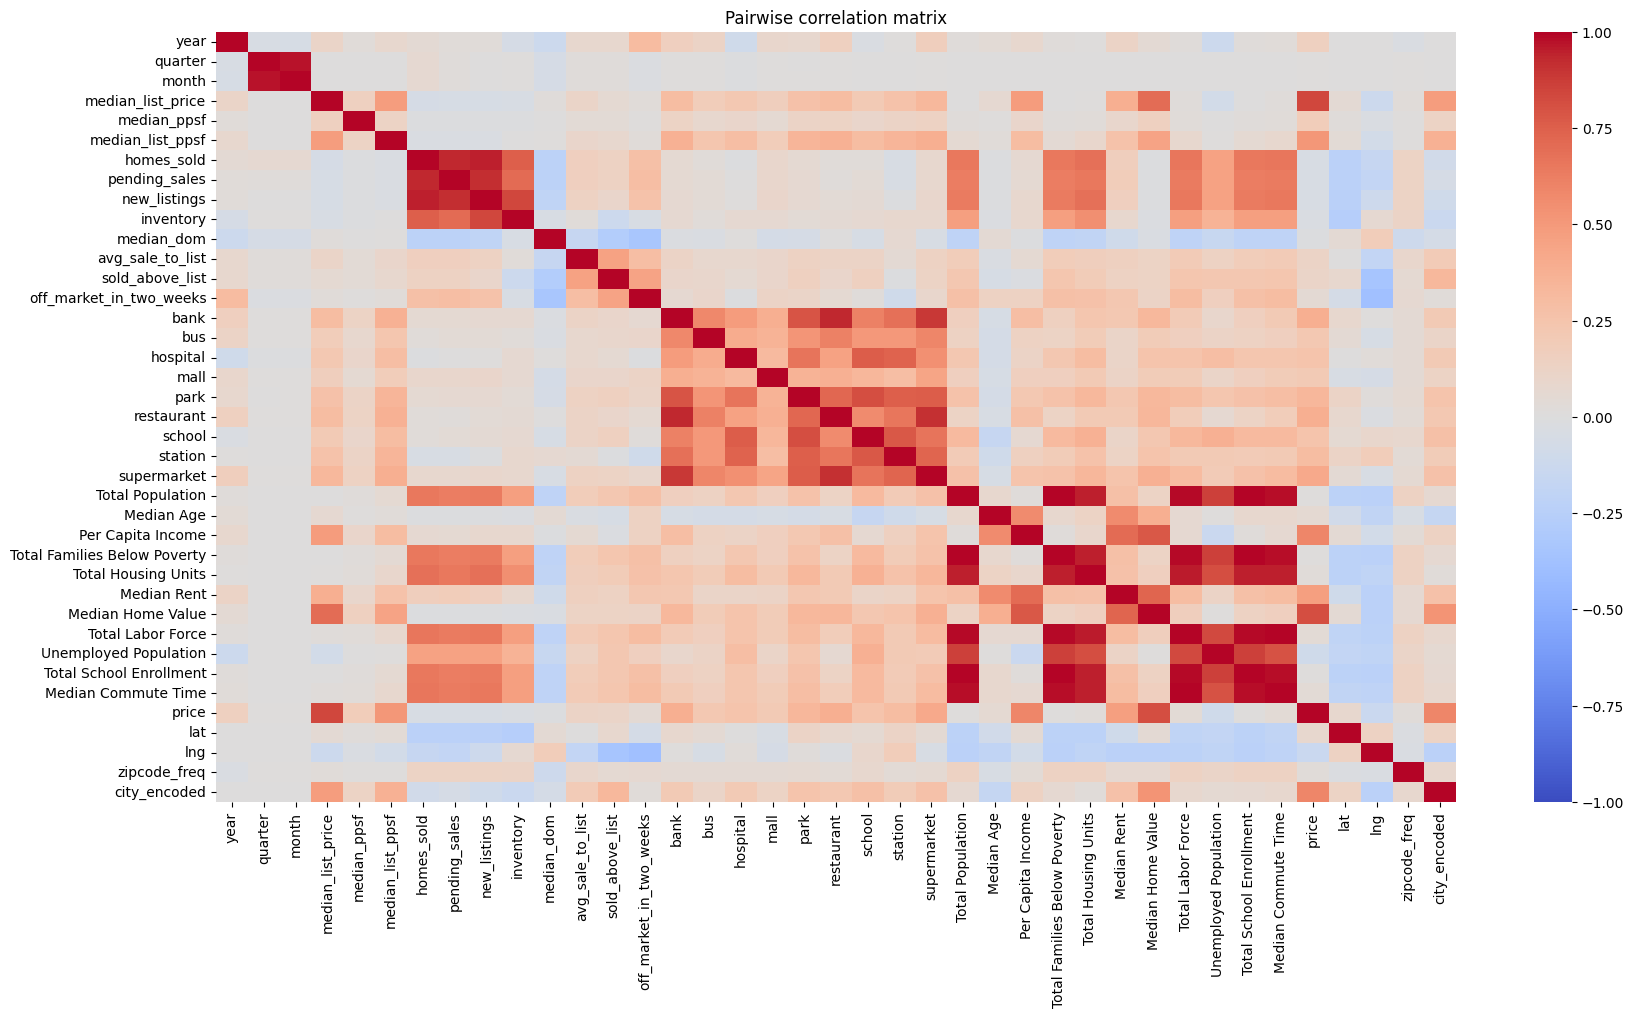

In [4]:
# Correlation Matrix

corr_matrix = df.corr().round(2)

# Visualizing the correlation matrix
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Pairwise correlation matrix")
plt.show()

In [5]:
# Variance Inflation Factor

def calculate_vif(df, target_col=None):
    """Calculate VIF for each numberic column in df"""

    # Keep numeric columns only
    numeric_df = df.select_dtypes(include=['float64', 'int64']).copy()

    # Drop target if provided
    if target_col and target_col in numeric_df.columns:
        numeric_df = numeric_df.drop(columns=[target_col])

    X = add_constant(numeric_df)

    # Calculate VIF for each feature
    vif_df = pd.DataFrame()
    vif_df["feature"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_df.sort_values(by="VIF", ascending=False).reset_index(drop=True)

# Look at VIF 
vif_data = calculate_vif(df, target_col='price')
vif_data

,feature,VIF
0,const,1.097804e+06
1,Total Population,6.661307e+03
2,Total School Enrollment,5.462753e+03
3,Total Labor Force,8.377304e+02
4,Median Commute Time,6.506769e+02
5,Total Families Below Poverty,5.761353e+02
6,Total Housing Units,2.111765e+01
7,new_listings,2.033283e+01
8,quarter,1.741866e+01
9,month,1.737738e+01


- If VIF > 10 : Serious Multi-collinearity
- If VIF > 100: Drop the feature, it is catastrophic
- If VIF = inf: Perfect linear redundancy (drop one)

In [ ]:
# Ignoring the constant & Not removing the median commute time for now as it might be a proxy for distance from transport options.

problematic_columns = ['Total Population', "Total Labor Force", "Total Families Below Poverty", "Total School Enrollment"]
df[problematic_columns].corr()

# Also we need to keep in mind that tree based models are inherently good at navigating high collinearity. 
# Regularization also handles it well, where L1 drops redundant features and L2 shrinks those redundant coefficients. Elastic Net is very good for very high collinearity


,Total Population,Total Labor Force,Total Families Below Poverty,Total School Enrollment
Total Population,1.000000,0.985546,0.998984,0.999875
Total Labor Force,0.985546,1.000000,0.985533,0.986053
Total Families Below Poverty,0.998984,0.985533,1.000000,0.998734
Total School Enrollment,0.999875,0.986053,0.998734,1.000000


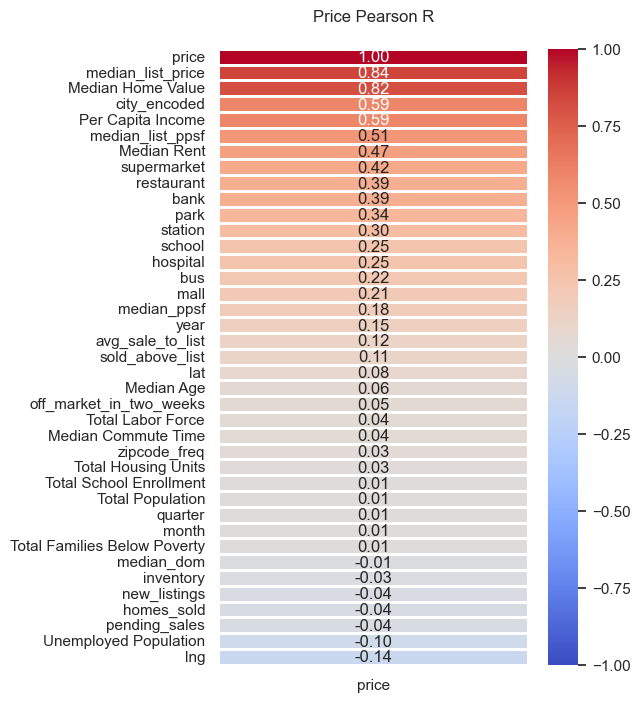

In [ ]:
# Compute correlation with price

num_cols = df.select_dtypes("number").columns
corr_vec = df[num_cols].corr(method="pearson")["price"].sort_values(ascending=False)
sns.set_theme(style="white")
plt.figure(figsize=(5,8))

ax = sns.heatmap(
    corr_vec.to_frame(),
    annot=True, fmt=".2f",
    vmin=-1, vmax=1,
    cmap="coolwarm",
    center=0,
    linewidth=1, linecolor="white",
)

ax.set_title("Price Pearson R", pad=20)
plt.show()

# We can infer that our offenders do not contribute anything to our target and at the same time hurt model stability by being highly multicollinear.
# We can also try to remove one of the two - median_list_price / Median Home Value

**Decision Flow**

High VIF 
   ↓
Low correlation with target?
   ↓ YES
Linear model + interpretability needed?
   ↓ YES → DROP
   ↓ NO -> Use regularization
Tree-based or regularized model?
   ↓ YES → KEEP or IGNORE VIF
